Загружаем необходимые библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVC
import medpy as mp

import matplotlib.pyplot as plt 

%matplotlib inline


import seaborn as sns
sns.set()



c:\python34x64\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\python34x64\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import glob

def plot_slices(image_data):
    plt.figure(figsize=(20,25))

    for ind, img_ind in enumerate(range(0, image_data.shape[2], 4)):
        img = image_data[:,:, img_ind]
        plt.subplot(np.ceil(image_data.shape[2] / 12), 3, ind + 1), plt.imshow(img, cmap='viridis')
        
def get_images_path(path_folder):
    images = []
    for ind, file_path in enumerate(glob.glob(path_folder + "*.img")):
#         image = io.imread(file_path)
        images.append(file_path)

    return images


# nilearn

In [3]:
from nilearn.image import index_img
import nilearn as nl


image_pathes = get_images_path('rsfMRI_eyeopen_2/C02_BORA_CEBECI/')
images_3d = nl.image.load_img(image_pathes)

## Producing single subject maps of seed-to-voxel correlation

In [4]:
from nilearn import input_data

func_filename = image_pathes
pcc_coords = [(0, -52, 18)]

seed_masker = input_data.NiftiSpheresMasker(
    pcc_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)

seed_time_series = seed_masker.fit_transform(func_filename)

In [6]:
brain_masker = input_data.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)

brain_time_series = brain_masker.fit_transform(func_filename)

In [7]:
print("seed time series shape: (%s, %s)" % seed_time_series.shape)
print("brain time series shape: (%s, %s)" % brain_time_series.shape)

seed time series shape: (200, 1)
brain time series shape: (200, 585346)


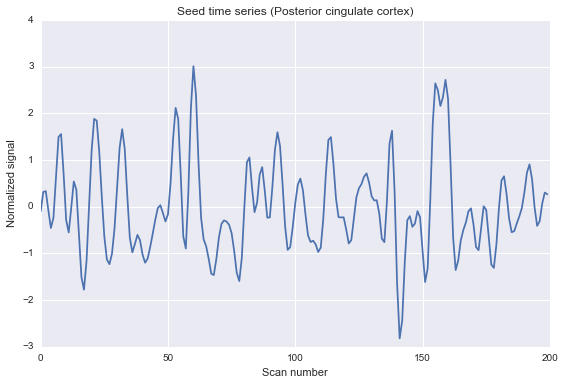

In [8]:
import matplotlib.pyplot as plt

plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

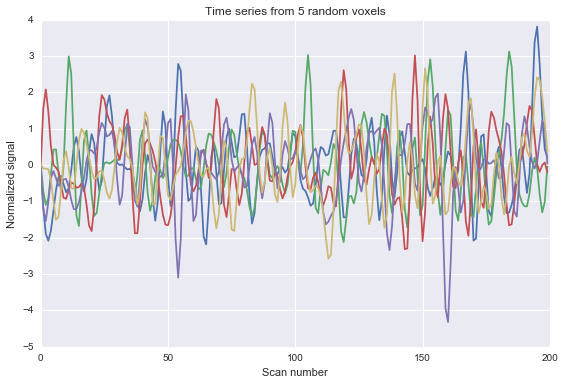

In [9]:
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [11]:
seed_based_correlations = np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
    
print("seed-based correlation shape: (%s, %s)" % seed_based_correlations.shape)
print("seed-based correlation: min = %.3f; max = %.3f" % (seed_based_correlations.min(), seed_based_correlations.max()))

seed-based correlation shape: (585346, 1)
seed-based correlation: min = -0.544; max = 0.994


In [14]:
seed_based_correlations_fisher_z = np.arctanh(seed_based_correlations)
print("seed-based correlation Fisher-z transformed: min = %.3f; max = %.3f" % (
    seed_based_correlations_fisher_z.min(),
    seed_based_correlations_fisher_z.max()))

# Finally, we can tranform the correlation array back to a Nifti image
# object, that we can save.
# seed_based_correlation_img = brain_masker.inverse_transform(seed_based_correlations.T)
# seed_based_correlation_img.to_filename('sbc_z.nii.gz')

seed-based correlation Fisher-z transformed: min = -0.609; max = 2.893


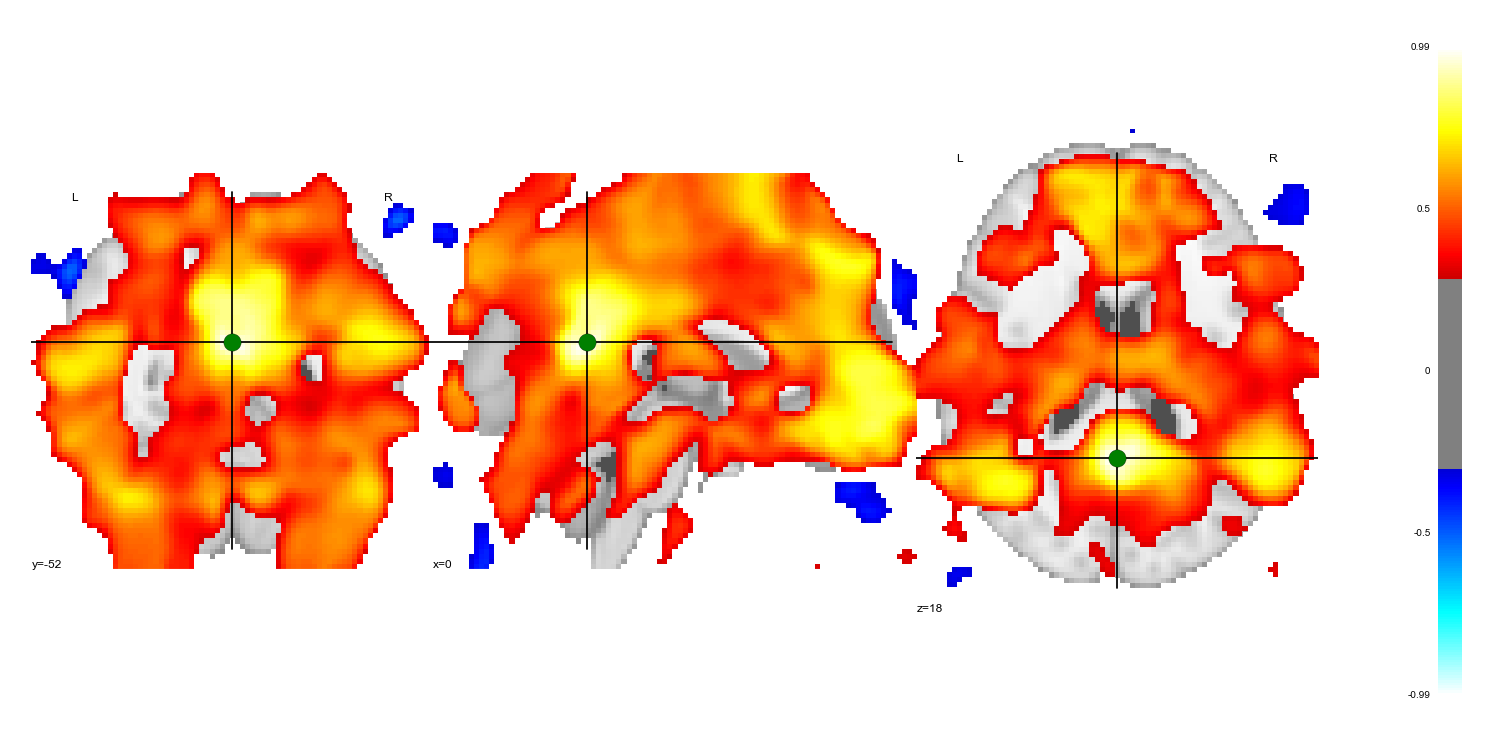

In [17]:
from nilearn import plotting

display = plotting.plot_stat_map(seed_based_correlation_img, threshold=0.3,
                                 cut_coords=pcc_coords[0],
                                 figure=plt.figure(figsize=(20, 10)))
display.add_markers(marker_coords=pcc_coords, marker_color='g',
                    marker_size=300)
# At last, we save the plot as pdf.
# display.savefig('sbc_z.pdf')

## Change colour 

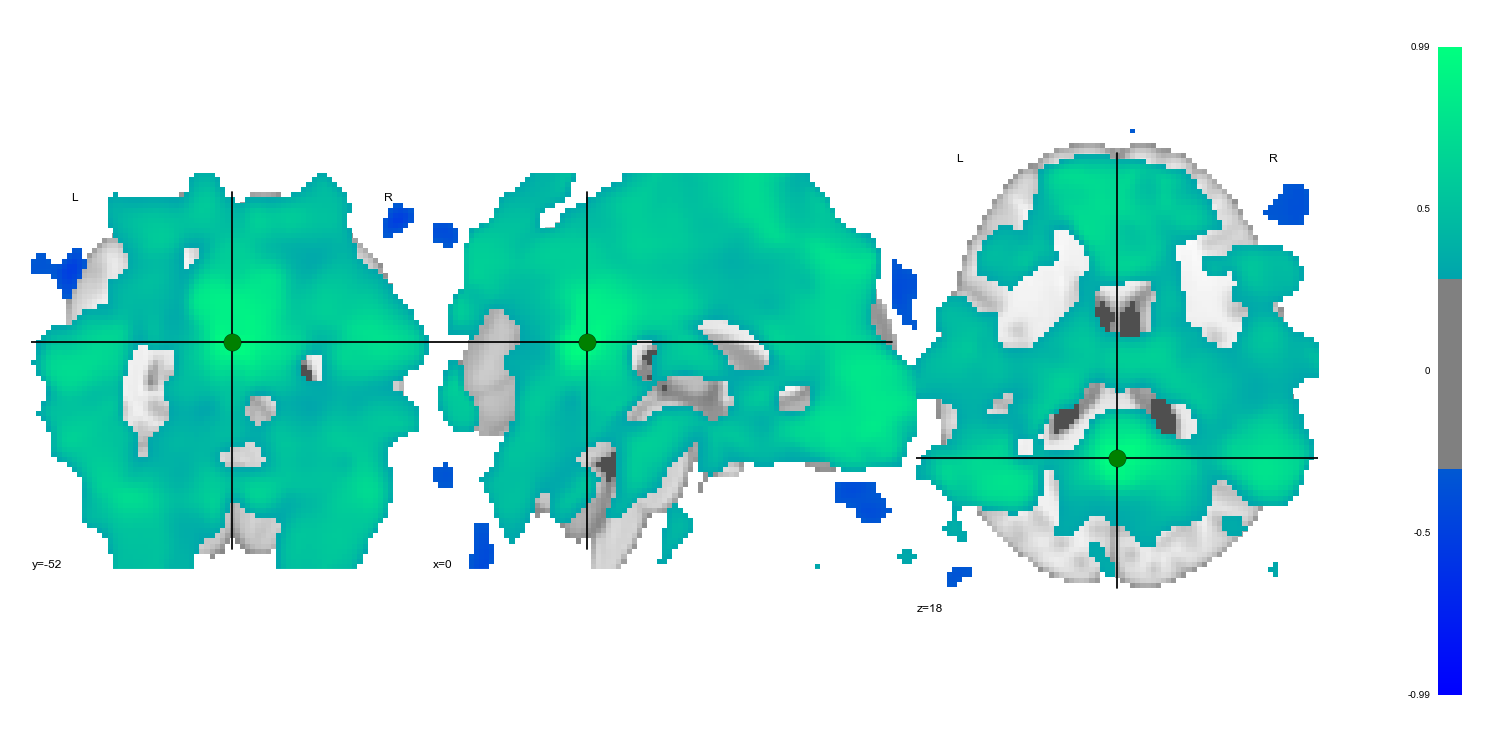

In [51]:
import matplotlib

cmap = matplotlib.cm.get_cmap(matplotlib.cm.winter)

display = plotting.plot_stat_map(seed_based_correlation_img, threshold=0.3,
                                 cut_coords=pcc_coords[0],
                                 figure=plt.figure(figsize=(20, 10), ),
                                 cmap=cmap
                            )

display.add_markers(marker_coords=pcc_coords, marker_color='g',
                    marker_size=300)

# Region Extraction for better brain parcellations

In [129]:
image_pathes = get_images_path('rsfMRI_eyeopen_2/C02_BORA_CEBECI/')
images_3d = nl.image.load_img(image_pathes)

In [ ]:
from nilearn.decomposition import DictLearning

func_filenames = image_pathes
# Initialize DictLearning object
dict_learn = DictLearning(n_components=3, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(func_filenames)
# Resting state networks/maps
components_img = dict_learn.masker_.inverse_transform(dict_learn.components_)

In [ ]:
components_img.get_data().shape

In [ ]:
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         figure=plt.figure(figsize=(20, 10)),
                         title='Dictionary Learning maps')

In [ ]:
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=135)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

In [ ]:
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 5))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         figure=plt.figure(figsize=(20, 10)),
                         title=title)

In [ ]:
from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
# for filename in func_filenames:
# call transform from RegionExtractor object to extract timeseries signals
timeseries_each_subject = extractor.transform(func_filenames)
# call fit_transform from ConnectivityMeasure object
correlation = connectome_measure.fit_transform([timeseries_each_subject])
# saving each subject correlation to correlations
correlations.append(correlation)

# Mean of all correlations
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

In [ ]:
mean_correlations.shape

In [ ]:
import matplotlib.pyplot as plt
from nilearn import image


           
regions_imgs = image.iter_img(regions_extracted_img)
coords_connectome = [plotting.find_xyz_cut_coords(img) for img in regions_imgs]
title = 'Correlation interactions between %d regions' % n_regions_extracted
plt.figure(figsize=(20, 10))
plt.imshow(mean_correlations, interpolation="nearest",
           vmax=1, vmin=-1, cmap=plt.cm.bwr)
plt.colorbar()
plt.title(title)
plt.figure(figsize=(20, 10))
plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title)

In [ ]:
# First, we plot a network of index=4 without region extraction (left plot)
img = image.index_img(components_img, 4)
coords = plotting.find_xyz_cut_coords(img)
display = plotting.plot_stat_map(img, cut_coords=coords,
                                 figure=plt.figure(figsize=(20, 10)),
                                 colorbar=False, title='Showing one specific network')

# Now, we plot (right side) same network after region extraction to show that
# connected regions are nicely seperated.
# Each brain extracted region is identified as separate color.

# For this, we take the indices of the all regions extracted related to original
# network given as 4.
regions_indices_of_map3 = np.where(np.array(regions_index) == 4)

display = plotting.plot_anat(cut_coords=coords,
                             figure=plt.figure(figsize=(20, 10)),
                             title='Extracted regions in one specific network')

# Now add as an overlay by looping over all the regions of index 4
# color list is random (you can choose your own color)
color_list = [[0., 1., 0.29, 1.], [0., 1., 0.54, 1.],
              [0., 1., 0.78, 1.], [0., 0.96, 1., 1.],
              [0., 0.73, 1., 1.], [0., 0.47, 1., 1.],
              [0., 0.22, 1., 1.], [0.01, 0., 1., 1.],
              [0.26, 0., 1., 1.]]
for each_index_of_map3, color in zip(regions_indices_of_map3[0], color_list):
    display.add_overlay(image.index_img(regions_extracted_img, each_index_of_map3),
                        cmap=plotting.cm.alpha_cmap(color))

plotting.show()